# Classification of cat sex based on their meows
https://www.kaggle.com/datasets/andrewmvd/cat-meow-classification/data

In [1]:
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import random
from sklearn import tree

## Procedure definitions

### 1. Extracting features from audio file used later for classification

In [2]:
def extract_features_from_waveform(data, sr):
    # Extract Mel-frequency cepstral coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=32).mean(axis=1)

    # Compute a chromagram from a waveform or power spectrogram
    chroma = librosa.feature.chroma_stft(y=data, sr=sr).mean(axis=1)

    # Extract Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=data, sr=sr).mean(axis=1)

    # Combine all features
    return np.hstack([mfccs, chroma, spectral_contrast])

### 2. Loading audio files from file path, trimming it (removing silence at the ends) and normalising the amplitude

In [3]:
def cleanse_audio(file_path, target_sample_rate=16000):
    # Load audio file
    data, sr = librosa.load(file_path, sr=None)

    # Trim silence from the beginning and end
    data, _ = librosa.effects.trim(data)

    # Resample to the target sample rate
    if sr != target_sample_rate:
        data = librosa.resample(data, orig_sr=sr, target_sr=target_sample_rate)
        sr = target_sample_rate

    # Normalize the audio to range [-1, 1]
    data = librosa.util.normalize(data)

    return data, sr

### 3. # target/ # all

In [4]:
def check_ratio(data, target):
    count = 0
    for i in data:
        if i == target:
            count += 1
    return (count / len(data))
    

### 4. Taking dataframe with X and y as string values, returning encoded X, y and all endocers (for future inverse transforming)

In [5]:
def divide_X_y(df, make_random = True):
    X_features = np.array(df['features'].tolist())
    
    context_encoder = LabelEncoder()
    breed_encoder = LabelEncoder()
    sex_encoder = LabelEncoder()
    
    # Transform the categorical columns into integers
    df['emission_context_encoded'] = context_encoder.fit_transform(df['emission_context'])
    df['breed_encoded'] = breed_encoder.fit_transform(df['breed'])
    
    # Extract the encoded columns as arrays
    X_context = df['emission_context_encoded'].to_numpy().reshape(-1, 1)
    X_breed = df['breed_encoded'].to_numpy().reshape(-1, 1)
    cat_id = df['cat_id'].to_numpy().reshape(-1, 1)
    # Combine features with the encoded categorical data
    X_combined = np.hstack([X_features, X_context, X_breed, cat_id])
    
    y = sex_encoder.fit_transform(df['sex'])  # Encode labels (sex)
    return X_combined, y, context_encoder, breed_encoder, sex_encoder

### 5. Splitting data X, y -> X_train, y_train, X_val, y_val, X_test, y_test
if by_cat_id == True   => the function will separate cats based on their IDs. Audio from a cat that is in test/vaidation set cannot be in the training set. This option makes the division not perfect, but >30% of the data wil be in test + validation set

if by_cat_id == False  => the function will not separate cats. (weak data leakage)

if random_state == None => function will shuffle data before division

In [6]:
def split_data(X_combined, y, by_cat_id: bool = True, random_state: int = None):
    X_combined, y = shuffle(X_combined, y, random_state=random_state)
    if not by_cat_id:
        X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y, test_size=0.3, random_state=random_state)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)
    else:
        perfect_num_for_test_val = 0.3 * len(X_combined)
        num_for_test_val = 0
        ID = -1
        X_test_val = []
        y_test_val = []
        i = 0
        seen_ids = set()
        current_id = ""
        while num_for_test_val < perfect_num_for_test_val:  
            # find new cat
            for cat in X_combined:
                if cat[ID] not in seen_ids: 
                    seen_ids.add(cat[ID])
                    current_id = cat[ID]
                    break
            # add all of its meows to the (test + validation) set
            for cat, i in zip(X_combined, y):
                if cat[ID] == current_id:
                    X_test_val.append(cat)
                    y_test_val.append(i)
                    num_for_test_val += 1
        X_train = []
        y_train = []
        # push all remainning cats to the train set
        for cat, i in zip(X_combined, y):
            if cat[ID] not in seen_ids:
                X_train.append(cat)
                y_train.append(i)
        X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=random_state)
        
        X_train = np.array(X_train)
        X_val = np.array(X_val)
        X_test = np.array(X_test)
        y_train = np.array(y_train)
        y_val = np.array(y_val)
        y_test = np.array(y_test)
    return X_train, y_train, X_val, y_val, X_test, y_test

Naming convention for files -> C_NNNNN_BB_SS_OOOOO_RXX, where:

C = emission context (values: B = brushing; F = waiting for food; I: isolation in an unfamiliar environment);

NNNNN = cat’s unique ID;

BB = breed (values: MC = Maine Coon; EU: European Shorthair);

SS = sex (values: FI = female, intact; FN: female, neutered; MI: male, intact; MN: male, neutered);

OOOOO = cat owner’s unique ID;

R = recording session (values: 1, 2 or 3)

XX = vocalization counter (values: 01..99)

e.g. 'B_ANI01_MC_FN_SIM01_102.wav'

In [7]:
def split_filename_from_db(file: str, include_neutering: bool = False):
    split = file.split('_')
    label_context = split[0]
    cat_id = split[1]
    label_breed = split[2]
    if include_neutering:
         label_sex = split[3]   # 4 classes  (FI = female, intact; FN: female, neutered; MI: male, intact; MN: male, neutered);
    label_sex = split[3][0]     # 2 classes (F - female, M - male)
    return label_context, cat_id, label_breed, label_sex

## Preprocess data
### Since male meows are undersampled I will augment the data by trippling every male sample with changed pitch and with added noise.

In [8]:
DATA_DIR = "dataset/dataset/"
audio_files = os.listdir(DATA_DIR)

count_male = 0
count_all = 0
data = []
count_files = len(audio_files)
for file in audio_files:
    count_all += 1
    label_context, cat_id, label_breed, label_sex = split_filename_from_db(file)
    file_path = os.path.join(DATA_DIR, file)

    # Load and cleanse audio
    audio_data, sr = cleanse_audio(file_path)

    # Extract features for the original audio
    features = extract_features_from_waveform(audio_data, sr)
    data.append([features, label_context, label_breed, label_sex, cat_id])

    # Augment male cat data
    #if label_sex in ['MI', 'MN']:
    if label_sex == 'M':
        count_all += 2
        count_male += 3
        # Apply pitch shifting
        data_shifted = librosa.effects.pitch_shift(audio_data, sr=sr, n_steps=2)
        features_shifted = extract_features_from_waveform(data_shifted, sr)
        data.append([features_shifted, label_context, label_breed, label_sex, cat_id + 'A1'])
        
        # Apply noise
        noise = 0.05 * np.random.randn(len(audio_data))
        data_noise = audio_data + noise
        features_noise = extract_features_from_waveform(data_noise, sr)
        data.append([features_noise, label_context, label_breed, label_sex, cat_id + 'A2'])

df = pd.DataFrame(data, columns=['features', 'emission_context', 'breed', 'sex', 'cat_id'])

### Now this is the % of male samples

In [9]:
print(f"{round(count_male/count_all, 3) * 100}%")

45.2%


### Divide dataframe to X and y.
also returns LabelEncoder()

In [10]:
X_combined, y, context_encoder, breed_encoder, sex_encoder = divide_X_y(df)

### Split data into 70% - train, 15% - test, 15% - validate

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X_combined, y, by_cat_id=True, random_state=40)

### Ratio of    
    (# female samples) / (# all samples)    
### for all data splits
if ratio > 0.70 the split should be remade, but I set the random_state = 40 so it splits nicely

In [12]:
check_ratio(y_train, sex_encoder.transform(['F']))

0.5186915887850467

In [13]:
check_ratio(y_test, sex_encoder.transform(['F']))

0.594059405940594

In [14]:
check_ratio(y_val, sex_encoder.transform(['F']))

0.6237623762376238

### Remove ID label from data 

In [15]:
X_train = X_train[:, :-1]
X_val = X_val[:, :-1]
X_test = X_test[:, :-1]

### Scale data

In [16]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Used for classifiers without division for validation and testing

In [17]:
X_tv = np.concatenate((X_test, X_val))
y_tv = np.concatenate((y_test, y_val))

## Neural Network with 2 hiden layers - 128 and 64 nodes

In [18]:
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.3),  # Dropout to prevent overfitting
    layers.Dense(64, activation='relu'),  # Second dense layer
    layers.Dropout(0.3),
    layers.Dense(len(np.unique(y)), activation='softmax')  # Output layer with softmax for classification
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6912      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 15298 (59.76 KB)
Trainable params: 15298 (59.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop training if validation loss doesn't improve for 3 epochs
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/100
7/7 [==============================] - 1s 28ms/step - loss: 0.7519 - accuracy: 0.6005 - val_loss: 0.3985 - val_accuracy: 0.8614
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 0.5162 - accuracy: 0.7243 - val_loss: 0.3536 - val_accuracy: 0.8416
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 0.4194 - accuracy: 0.8014 - val_loss: 0.3188 - val_accuracy: 0.8515
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: 0.3643 - accuracy: 0.8248 - val_loss: 0.3343 - val_accuracy: 0.8515
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 0.3363 - accuracy: 0.8458 - val_loss: 0.3537 - val_accuracy: 0.8119
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 0.3026 - accuracy: 0.8621 - val_loss: 0.3658 - val_accuracy: 0.8218


### Evaluate on the test set

In [20]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

4/4 [==============================] - 0s 1ms/step - loss: 0.2607 - accuracy: 0.9307
Test Loss: 0.2607
Test Accuracy: 0.9307


4/4 [==============================] - 0s 1ms/step


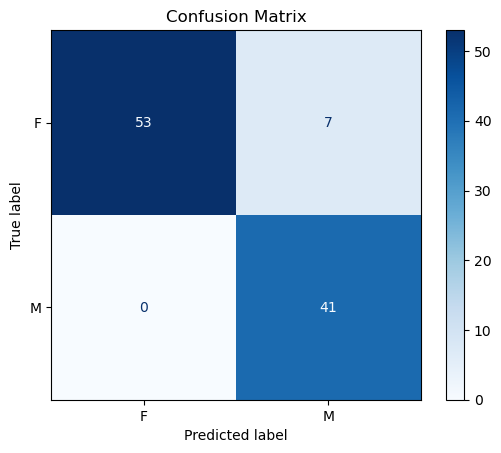

In [21]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test)  # Output will be probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices


# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sex_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer format
plt.title("Confusion Matrix")
plt.show()

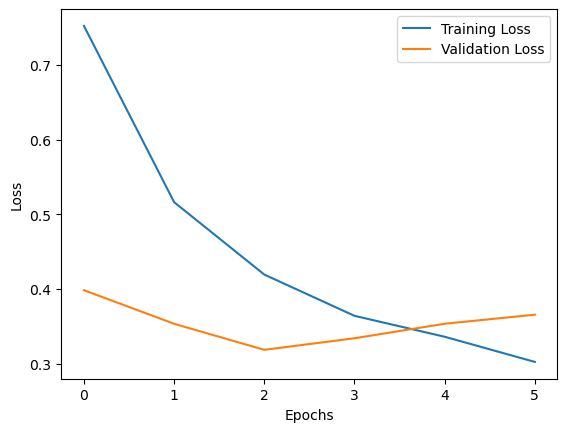

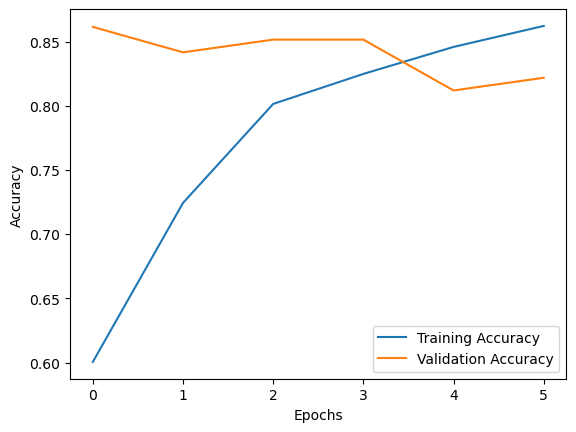

In [22]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Classify a set of audiofiles in a directory by this Neural Network
the audio file can be named with the naming convention otherwise the arguments "label_context, label_breed" should be provided 

In [23]:
def test_audio_files_from_directory_nn(directory: str, label_context: str = "", label_breed: str = ""):
    test_files = os.listdir(directory)
    predictions = []
    for file in test_files:
        split = file.split('_')
        if label_context == "":
            label_context = split[0]
        if label_breed == "":
            label_breed = split[2]
        file_path = os.path.join(directory, file)
        audio_data, sr = cleanse_audio(file_path)
        features = extract_features_from_waveform(audio_data, sr)
        
        X_features = np.array([features])
    
        encoded_context = context_encoder.transform([label_context])
        encoded_breed = breed_encoder.transform([label_breed])
        
        X_context = encoded_context.reshape(-1, 1)
        X_breed = encoded_breed.reshape(-1, 1)
        
        X_combined = np.hstack([X_features, X_context, X_breed])
        X_combined = scaler.transform(X_combined)
        
        prob_prediction = model.predict(X_combined)
        predictions.append(sex_encoder.inverse_transform(np.argmax(prob_prediction, axis=1))[0])
        
    return predictions

In [26]:
sex = []
test_files = os.listdir("testset/")
for file in test_files:
    split = file.split('_')
    sex.append(split[3])

In [27]:
print(test_audio_files_from_directory_nn("testset/"))
print(sex)

1/1 [==============================] - 0s 13ms/step
['M', 'M', 'M', 'M']
['FN', 'FN', 'FN', 'MN']


## Procedures for less advanced classifiers

### Train any Classifier from sklearn

In [28]:
from sklearn.base import ClassifierMixin
def train(Classifier: ClassifierMixin):
    global X_tv, y_tv, X_train, y_train
    Classifier.fit(X_train, y_train)
    pred = Classifier.predict(X_tv)
    train_acc = Classifier.score(X_train, y_train)
    test_acc = Classifier.score(X_tv, y_tv)
    return Classifier, train_acc, test_acc, pred

### Classify a set of audiofiles in a directory by a classifier
the audio file can be named with the naming convention otherwise the arguments "label_context, label_breed" should be provided

In [29]:
def test_audio_files_from_directory_classifier(directory: str, Classifier: ClassifierMixin, label_context: str = "", label_breed: str = ""):
    test_files = os.listdir(directory)
    predictions = []
    for file in test_files:
        split = file.split('_')
        if label_context == "":
            label_context = split[0]
        if label_breed == "":
            label_breed = split[2]
        file_path = os.path.join(directory, file)
        audio_data, sr = cleanse_audio(file_path)
        features = extract_features_from_waveform(audio_data, sr)
        
        X_features = np.array([features])
    
        encoded_context = context_encoder.transform([label_context])
        encoded_breed = breed_encoder.transform([label_breed])
        
        X_context = encoded_context.reshape(-1, 1)
        X_breed = encoded_breed.reshape(-1, 1)
        
        X_combined = np.hstack([X_features, X_context, X_breed])
        X_combined = scaler.transform(X_combined)
        
        prediction = Classifier.predict(X_combined)
        predictions.append(sex_encoder.inverse_transform(prediction))
        
    return predictions

### Confusion Matrix for given predicion values

In [30]:
def show_cmatrix(y_pred):
    global y_tv
    cm = confusion_matrix(y_tv, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sex_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer format
    plt.title("Confusion Matrix")
    plt.show()

## Simple classification

### DecisionTreeClassifier

In [31]:
from sklearn.tree import DecisionTreeClassifier
dtc, train_acc, test_acc, y_pred = train(DecisionTreeClassifier(random_state=0, max_depth=2, min_samples_leaf=10))
print(train_acc)
print(test_acc)

0.852803738317757
0.7772277227722773


[Text(0.5, 0.8333333333333334, 'x[14] <= -0.303\ngini = 0.499\nsamples = 428\nvalue = [222, 206]'),
 Text(0.25, 0.5, 'x[17] <= 0.412\ngini = 0.131\nsamples = 142\nvalue = [10, 132]'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.031\nsamples = 128\nvalue = [2, 126]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.49\nsamples = 14\nvalue = [8, 6]'),
 Text(0.75, 0.5, 'x[12] <= 1.03\ngini = 0.384\nsamples = 286\nvalue = [212, 74]'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.307\nsamples = 253\nvalue = [205, 48]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.334\nsamples = 33\nvalue = [7, 26]')]

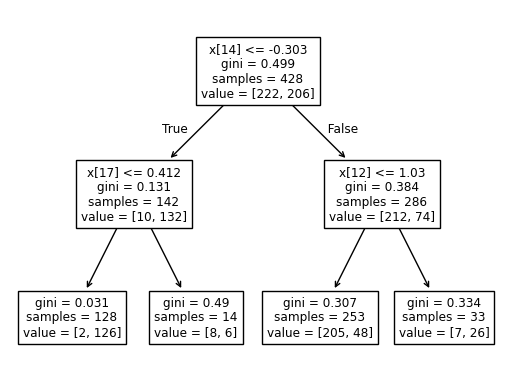

In [32]:
tree.plot_tree(dtc)

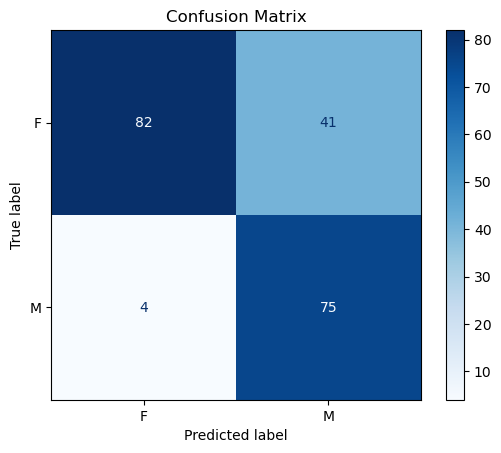

In [33]:
show_cmatrix(y_pred)

In [34]:
test_audio_files_from_directory_classifier("testset/", dtc)

[array(['F'], dtype=object),
 array(['F'], dtype=object),
 array(['M'], dtype=object),
 array(['M'], dtype=object)]

### RandomForestClassifier

In [35]:
from sklearn.ensemble import RandomForestClassifier
rfc, train_acc, test_acc, y_pred = train(RandomForestClassifier(max_depth=2, random_state=2))
print(train_acc)
print(test_acc)

0.8364485981308412
0.8910891089108911


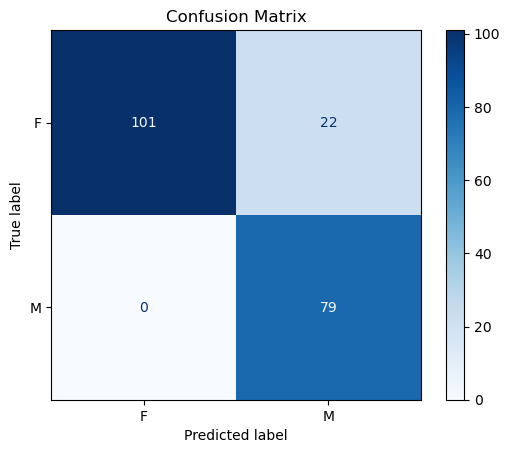

In [36]:
show_cmatrix(y_pred)

In [37]:
test_audio_files_from_directory_classifier("testset/", rfc)

[array(['M'], dtype=object),
 array(['M'], dtype=object),
 array(['M'], dtype=object),
 array(['M'], dtype=object)]

### KNeighborsClassifier

In [38]:
from sklearn.neighbors import KNeighborsClassifier
neigh, train_acc, test_acc, y_pred = train(KNeighborsClassifier(n_neighbors=13))
print(train_acc)
print(test_acc)

0.9042056074766355
0.8514851485148515


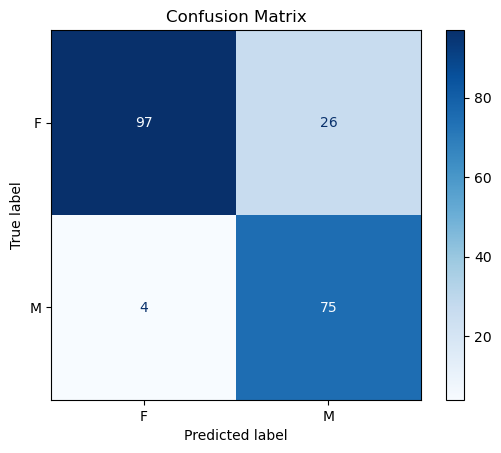

In [39]:
show_cmatrix(y_pred)

In [40]:
test_audio_files_from_directory_classifier("testset/", neigh)

[array(['F'], dtype=object),
 array(['F'], dtype=object),
 array(['F'], dtype=object),
 array(['F'], dtype=object)]